# ------------------------------------------------------------------------

#      Thermal Sensitivity Analysis Script

##   Developed by Ryan Niemeyer and Yifan Cheng - University of Washington

#### Description: The purpose of this script is to take an idealized case of streamflow with a specific discharge and stream temperature, simulate input of thermal effluent (i.e. warm discharge water from power plant), and calculate the temperature for each subsequent time step (i.e. it's langrangian - although it doesn't track the parcel in space, but in time).  The equiplibrium temperature is calculated at each time step based on equation 19 in Edinger et al. (1968).  
# ------------------------------------------------------------------------

# ------------------------------------------------------------------------
#    Upload Packages
# ------------------------------------------------------------------------

In [1]:
import sys
import numpy as np
import xray
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp, expm1

from pylab import *
import matplotlib.pyplot  as pyplot
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

% matplotlib inline

# ------------------------------------------------------------------------
#    Define Constants
# ------------------------------------------------------------------------

In [4]:
# -------------------- general parameters and constants -----------------------
evap_coeff=1.5e-9 # evaporation coefficient
pf=0.640 # not sure what this variable is
c_p=0.0000041484 # heat capacity of water in MegaJoules/gram*degC
c_p_j= 4148.4 # heat capacity of water in Joules/kg*degC
water_density = 1000 # kg/m3

# -------------------- Leopold depth parameters -----------------------
# flow depth = z a*(Q**b)
a_d = 0.408
b_d = 0.392

# -------------------- conversions -----------------------
MW_to_Jsec = 1000000 # converts MW to Joules/sec
kcal_to_J = 4184   # converts kcal to Joules
m3sec_to_ft3sec = 35.3147  
m_to_ft = 3.28084
MW_to_Btu = 3.412
Btu_kWh_to_MMBtu_MWh = 0.001
MMBtu_day_to_MW_hr = 0.293071 
sec_per_day = 86400
Joules_per_Btu = 1055.06
MMBtu_per_Joules = 9.4708E-10


# ------------------------------------------------------------------------
#    Define Functions
# ------------------------------------------------------------------------

In [5]:
def calc_surf_energy(T_i,dbt,ea, q_ns, q_na, wind):
    
    """
    Equation to calculate surface energy, equilibrium temperature, and constant k
    Based on River Basin Model (RBM) 'Energy.f90' subroutine. 
    
    """
    
    # do linear fit of temperature between two T_fit
    T_fit = []
    T_fit.append(T_i - 1.0)
    T_fit.append(T_i + 1.0)
    
    q_fit = [] # q_fit empty list

    # loop between two T_fit temperatures
    for i in range(0,2):
        # calculate energy from evaporation
        e0 = 2.1718e8*exp((-4157.0) /(T_fit[i] + 239.09)) # calc saturation vap pressure
        lvp = 597 - (0.57 * T_fit[i])
                        # calc latent heat of vapor
        q_evap=1000.*lvp*evap_coeff*wind
        if q_evap.values < 0: 
            q_evap=0
        q_evap=q_evap*(e0-ea)

        # calculate energy tranfser from convection
        rb=pf*(dbt-T_fit[i])
        q_conv=rb*q_evap

        # calculate loss of land surface longwave radiation
        q_ws=6.693e-2 + 1.471e-3 * T_fit[i]

        # calculate all energy components (units = kcal/sec*m2) 
        q_fit.append(q_ns + q_na - q_ws - q_evap + q_conv)

#
#     q=AT+B
#
#     Linear fit over the range of 2.0 deg C.
#     These results can be used to estimate the "equilibrium" 
#     temperature and linear rate constant.
#
    A = (q_fit[0] - q_fit[1]) / (T_fit[0] - T_fit[1]) #units: kcal/sec * m2 * deg C
    q_surf=0.5*(q_fit[0]+q_fit[1]) # units: kcal/sec * m2
    # B=(q_surf/A)-(T_fit[0]+T_fit[1])/2 # incorrect - in original Energy.f90 code
    B = q_surf - (A *(T_fit[0]+T_fit[1])/2)

    # calculate equilibrium temperature and k_coefficient 
    T_equil = (-1)*(B/A)  # deg C
    k_coeff = A
    
    return q_surf, T_equil, k_coeff

In [6]:
def waste_heat_fxn(q_power, heat_rate):
    # waste heat = ((1-efficiency)/efficiency)* power_plant_capacity
    # efficiency = 1/heatInput  # heatInput = Btu/kWh [energy/electricity], efficiency is inverse
    
    heat_rate = heat_rate * Btu_kWh_to_MMBtu_MWh  # convert  [Btu/kWh] to [MMBtu/MWh]
    efficiency = MW_to_Btu/heat_rate # produces inverse and converts to MW/Btu
    waste_heat = ((1 - efficiency )/efficiency) * (q_power ) # [MW]
    waste_heat = waste_heat * MW_to_Jsec  # [J/sec]
    
    return waste_heat  # output in Joules per sescond

In [43]:
def calc_stream_temperature_1_plant(T_stream, T_eq, k_coeff, q_power, Q, depth,stream_vel, impulse_fxn2, distx, sub_distx, dist_impulse, time_stepx):
    
    """
    
    Equation to calculate the stream temperature
    based on the analytical solution of the Edenger et al. (1968), equation #19
    
    """

    timex = (distx + sub_distx/(len(steps_per_km)))/stream_vel # calculate distance traveled in seconds
    time_impulse_sec = dist_impulse/stream_vel # convert location of power plant effluent impulse (km) to seconds based on velocity
    k_coeff = k_coeff * kcal_to_J # convert kcal/sec*m2*C to Joules/sec*m2*C
    alpha = k_coeff/(water_density * c_p_j * depth) # alpha parameter from solution
    beta = (q_power * a_const)/(water_density * c_p_j * Q) # calculate beta parameter
    power_x  = impulse_fxn2[distx]*beta*exp((-1)*alpha[0]*(timex - time_impulse_sec)) # calculate power plant term
    stream_x = (T_stream - T_eq)*exp((-1)*alpha[0]*timex) + T_eq + power_x   #  calculate stream temperature at timex
    
    return stream_x

In [79]:
def calc_stream_temperature_2_plants(T_stream, T_eq, k_coeff, q_power1, q_power2, Q, depth,stream_vel, impulse_fxn_plant1, 
                                     impulse_fxn_plant2, distx, sub_distx,dist_impulse1,dist_impulse2):
    
    """
    
    Equation to calculate the stream temperature downstream of two power plants in sequence
    based on the analytical solution of the Edenger et al. (1968), equation #19
    
    """

    timex = (distx + sub_distx/(len(steps_per_km)))/stream_vel # calculate distance traveled in seconds
    time_impulse_sec1 = dist_impulse1/stream_vel # convert location of power plant effluent impulse (km) to seconds based on velocity
    time_impulse_sec2 = dist_impulse2/stream_vel # convert location of power plant effluent impulse (km) to seconds based on velocity
    k_coeff = k_coeff * kcal_to_J # convert kcal/sec*m2*C to Joules/sec*m2*C
    alpha = k_coeff/(water_density * c_p_j * depth) # alpha parameter from solution
    beta1 = (q_power1 * a_const)/(water_density * c_p_j * Q) # calculate beta parameter for power plant 1
    beta2 = (q_power2 * a_const)/(water_density * c_p_j * Q) # calculate beta parameter for power plant 2
    power_x1 = impulse_fxn_plant1[distx]*beta1*exp((-1)*alpha[0]*(timex - time_impulse_sec1)) # calculate power plant term
    power_x2 = impulse_fxn_plant2[distx]*beta2*exp((-1)*alpha[0]*(timex - time_impulse_sec2)) # calculate power plant term
    stream_x = (T_stream - T_eq)*exp((-1)*alpha[0]*timex) + T_eq + power_x1 + power_x2   #  calculate stream temperature at timex

    return stream_x

In [45]:
def impseq2(n0,n1,n2):
    """
   Returns Impulse Sequence Response
   n0: day of impulse (power plant input)
   n1: first day (typically 1)
   n2: last day
   """
    if (n0 < n1) or (n0 > n2) or (n1 > n2):
        print('Arguments must satisfy n1 <= n0 <= n2')
        return
    n = [0] * (n2 - n1 )
    x1 = n0
    x2 = n2
    n[x1:x2] = np.repeat(1,x2-x1)
    # previous to just have one '1' value: n[n0-1] = 1
    return n

# ------------------------------------------------------------------------
#   Loop to loop through scenarios: ONE PLANT
# ------------------------------------------------------------------------

In [196]:
# --------------------------------------------------
#  Analytial Solution - loop through all scenarios 
# ---------------------------------------

# --------- input variables ------------
# variable list: Q(m3/sec), depth(m), stream_velocity(km/sec) T_stream - initial(deg C), dry bulb temp (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec),
# q_na (kcal/m2*sec),  wind (m/sec), location of power plant effluent discharge (km), distance between calculations (km)
input_vars = pd.DataFrame([100,  5.27e-4,  28.481531,  30, 900,  0.02, 0.05,  2, 4, 0.1])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','stream_velocity', 'T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind', 'power_plant_km', 'dist_between']
a_const = 1
heat_x = 20500  # constant heat rate in Btu/kWh (max observed in SERC = 20,500)

# ----- establish time series with power plant impulse ---------
km1 = 0 # first distance
km2 = 30 # final distance
impulse_distance_series = impseq2(int(input_vars['power_plant_km'][0]),km1,km2)

# ------- flow and power plant capacity scenarios ------------
power_plant_range = [1000,2000,3000,4000] # power plant capacity (MW)
Q_range = [100,1000,10000, 100000] # discharge range (m3/sec)

# ------- data frames and lists to write data -------
T_stream_tot = [] # list of stream temperature time series
scenarios_tot_Q = [] # list of streamflow scenarios
scenarios_tot_P = [] # list of power plant capacity scenarios
T_equil = [] # list of equilibrium temperatures

# ------------------- loop through all power plant capacity scenarios ------------------
for power_x in power_plant_range:
    
    # --------- loop through all flow scenarios ---------
    for flow_x in Q_range:
        
        T_stream_list2 = [] # empty list to write stream T time series

        # ------------- calculate surface energy, T_equil., and k_coeff -------    
        q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],
                input_vars['vap_press'],input_vars['q_ns'],input_vars['q_na'],
                input_vars['wind'])
        T_equil.append(T_eq)
        # -------------------- calculate power plant waste heat output ----------------
        #q_power = power_plant_efficiency(power_x, 0.35)
        waste_heat = waste_heat_fxn(power_x, heat_x) # output [J/sec]
        
        # --------------- calculate flow depth --------------------
        depth_x = a_d * ((flow_x*m3sec_to_ft3sec)**b_d) # depth in feet
        depth_x = depth_x /m_to_ft  # depth in meters

        # -------------- print scenarios -----------
        print('power: ',power_x, ' flow: ',flow_x, ' depth: ',depth_x)   
        
        # ------------- loop through each hour of time series -----------
        for i in range(len(impulse_distance_series)):

            steps_per_km = list(range(0,int(1/input_vars['dist_between']))) # list with total time steps in each hour
            
            # update steps_per_hr if more than one time step per hour
            if len(steps_per_km) < 1:
                steps_per_km =  list([1])
            
            # loop through each time step in the hour and calculate stream temperature
            for j in steps_per_km:
                T_stream_new = calc_stream_temperature_1_plant(input_vars['T_stream_i'], T_eq, k_coeff, waste_heat, 
                    flow_x, depth_x, input_vars['stream_velocity'][0],
                    impulse_distance_series, i, j,int(input_vars['power_plant_km'][0]),input_vars['dist_between'] )
                
                T_stream_list2.append(T_stream_new)

        # --------- write each scenario ------
        scenarios_tot_Q.append(flow_x)
        scenarios_tot_P.append(power_x)
        # ------- append new time series of stream temperatures --------
        T_stream_tot.append(T_stream_list2)

power:  1000  flow:  100  depth:  3.058254871467102
power:  1000  flow:  1000  depth:  7.541776816326421
power:  1000  flow:  10000  depth:  18.598318301702914
power:  1000  flow:  100000  depth:  45.864184538404736
power:  2000  flow:  100  depth:  3.058254871467102
power:  2000  flow:  1000  depth:  7.541776816326421
power:  2000  flow:  10000  depth:  18.598318301702914
power:  2000  flow:  100000  depth:  45.864184538404736
power:  3000  flow:  100  depth:  3.058254871467102
power:  3000  flow:  1000  depth:  7.541776816326421
power:  3000  flow:  10000  depth:  18.598318301702914
power:  3000  flow:  100000  depth:  45.864184538404736
power:  4000  flow:  100  depth:  3.058254871467102
power:  4000  flow:  1000  depth:  7.541776816326421
power:  4000  flow:  10000  depth:  18.598318301702914
power:  4000  flow:  100000  depth:  45.864184538404736


# ------------------------------------------------------------------------
#   Loop to loop through scenarios: TWO PLANTS
# ------------------------------------------------------------------------

In [107]:
# --------------------------------------------------
#  Analytial Solution - loop through all scenarios 
# ---------------------------------------

# --------- input variables ------------
# variable list: Q(m3/sec), depth(m), stream_velocity(km/sec) T_stream - initial(deg C), dry bulb temp (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec),
# q_na (kcal/m2*sec),  wind (m/sec), location of power plant effluent discharge (km), distance between calculations (km)
input_vars = pd.DataFrame([100,  5.27e-4,  28.481531,  30, 900,  0.02, 0.05,  2, 2, 25, 0.1])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','stream_velocity', 'T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind',
                      'power_plant_km1','power_plant_km2' , 'dist_between']

a_const = 1
heat_x1 = 20500 # 9558 heat rate [Btu/kWh] of Marshall
heat_x2 = 20500 # 10460 heat rate [Btu/kWh] of McGuire

# ----- establish time series with power plant impulse ---------
km1 = 0 # first distance
km2 = 45 # final distance
impulse_distance_series1 = impseq2(int(input_vars['power_plant_km1'][0]),km1,km2)
impulse_distance_series2 = impseq2(int(input_vars['power_plant_km2'][0]),km1,km2)

# ------- flow and power plant capacity scenarios ------------
power_plant_range = [1000,2000,3000,4000] # power plant capacity (MW)
Q_range = [100,1000,10000, 100000] # discharge range (m3/sec)

# ------- data frames and lists to write data -------
T_stream_tot = []
scenarios_tot_Q = []
scenarios_tot_P = []
T_equil = []

for power_x in power_plant_range:
    
    for flow_x in Q_range:
        
        T_stream_list2 = []

        # ------------- calculate surface energy, T_equil., and k_coeff -------    
        q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],
                input_vars['vap_press'],input_vars['q_ns'],input_vars['q_na'],
                input_vars['wind'])
        T_equil.append(T_eq)
        
        # -------------------- calculate power plant waste heat output ----------------
        waste_heat1 = waste_heat_fxn(power_x, heat_x1) # output [J/sec]
        waste_heat2 = waste_heat_fxn(power_x, heat_x2) # output [J/sec]
        
        # --------------- calculate flow depth --------------------
        depth_x = a_d * ((flow_x*m3sec_to_ft3sec)**b_d) # depth in feet
        depth_x = depth_x /m_to_ft  # depth in meters

        print('power: ',power_x, ' flow: ',flow_x, ' depth: ',depth_x)   
        
        # ------------- loop through each hour of time series -----------
        for i in range(len(impulse_distance_series1)):

            steps_per_km = list(range(0,int(1/input_vars['dist_between']))) # list with total time steps in each hour
            
            # update steps_per_hr if more than one time step per hour
            if len(steps_per_km) < 1:
                steps_per_km =  list([1])
            
            # loop through each time step in the hour and calculate stream temperature
            for j in steps_per_km:
                T_stream_new = calc_stream_temperature_2_plants(input_vars['T_stream_i'], T_eq, k_coeff, waste_heat1, waste_heat2, 
                    flow_x, depth_x, input_vars['stream_velocity'][0], impulse_distance_series1, impulse_distance_series2, 
                    i, j,int(input_vars['power_plant_km1'][0]),int(input_vars['power_plant_km2'][0]) )
                T_stream_list2.append(T_stream_new)
  
        scenarios_tot_Q.append(flow_x)
        scenarios_tot_P.append(power_x)
        T_stream_tot.append(T_stream_list2)

power:  1000  flow:  100  depth:  3.058254871467102
power:  1000  flow:  1000  depth:  7.541776816326421
power:  1000  flow:  10000  depth:  18.598318301702914
power:  1000  flow:  100000  depth:  45.864184538404736
power:  2000  flow:  100  depth:  3.058254871467102
power:  2000  flow:  1000  depth:  7.541776816326421
power:  2000  flow:  10000  depth:  18.598318301702914
power:  2000  flow:  100000  depth:  45.864184538404736
power:  3000  flow:  100  depth:  3.058254871467102
power:  3000  flow:  1000  depth:  7.541776816326421
power:  3000  flow:  10000  depth:  18.598318301702914
power:  3000  flow:  100000  depth:  45.864184538404736
power:  4000  flow:  100  depth:  3.058254871467102
power:  4000  flow:  1000  depth:  7.541776816326421
power:  4000  flow:  10000  depth:  18.598318301702914
power:  4000  flow:  100000  depth:  45.864184538404736


# -----------------------------------------------------------------------------------------
#   TWO power plants in sequence: use the SPECIFIC info for each plant
#     use Leopold Parameters for Depth
# -----------------------------------------------------------------------------------------

In [190]:
# --------------------------------------------------
#  Analytial Solution - loop through all scenarios 
# ---------------------------------------


# --------- input variables ------------
# variable list: Q(m3/sec), depth(m), stream_velocity(km/sec) T_stream - initial(deg C), dry bulb temp (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec),
# q_na (kcal/m2*sec),  wind (m/sec), location of power plant effluent discharge (km), distance between calculations (km)
input_vars = pd.DataFrame([100,  5.27e-4,  28.481531,  30, 900,  0.02, 0.05,  2, 2, 25, 0.1])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','stream_velocity', 'T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind',
                      'power_plant_km1','power_plant_km2' , 'dist_between']

a_const = 1
heat_x1 = 20500 # 9558 heat rate [Btu/kWh] of Marshall
heat_x2 = 20500 # 10460 heat rate [Btu/kWh] of McGuire

# ----- establish time series with power plant impulse ---------
km1 = 0 # first distance
km2 = 45 # final distance
impulse_distance_series1 = impseq2(int(input_vars['power_plant_km1'][0]),km1,km2)
impulse_distance_series2 = impseq2(int(input_vars['power_plant_km2'][0]),km1,km2)

# ------- flow and power plant capacity scenarios ------------
power_plant_range = [1000,2000,3000,4000] # power plant capacity (MW)
Q_range = [100,1000,10000, 100000] # discharge range (m3/sec)

# ------- data frames and lists to write data -------
T_stream_tot = []
scenarios_tot_Q = []
scenarios_tot_P = []
T_equil = []


T_stream_tot_2 = []
heat_x1 = 9558 # heat rate [Btu/kWh] of Marshall
heat_x2 = 10460 # heat rate [Btu/kWh] of McGuire

flow_x = 3134/m3sec_to_ft3sec # cfs - lowest minimum flow at Marshall (nearby USGS site)

power_x1 = 2078 # [MW]
power_x2 = 2316 # [MW]

T_stream_list2 = []

# ------------- calculate surface energy, T_equil., and k_coeff -------    
q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],
        input_vars['vap_press'],input_vars['q_ns'],input_vars['q_na'],
        input_vars['wind'])
T_equil.append(T_eq)

# -------------------- calculate power plant waste heat output ----------------
#q_power = power_plant_efficiency(power_x, 0.35)
waste_heat1 = waste_heat_fxn(power_x1, heat_x1) # output [J/sec]
waste_heat2 = waste_heat_fxn(power_x2, heat_x2) # output [J/sec]

# --------------- calculate flow depth --------------------
depth_x = a_d * ((flow_x*m3sec_to_ft3sec)**b_d) # depth in feet
depth_x = depth_x /m_to_ft  # depth in meters

for i in range(len(impulse_distance_series1)):

    steps_per_hr = list(range(0,int(1/input_vars['dist_between'])))
    #print(len(steps_per_hr))

    if len(steps_per_km) < 1:
        steps_per_km =  list([1])

    for j in steps_per_hr:
        T_stream_new = calc_stream_temperature_2_plants(input_vars['T_stream_i'], T_eq, k_coeff, waste_heat1, waste_heat2, 
            flow_x, depth_x, input_vars['stream_velocity'][0], impulse_distance_series1, impulse_distance_series2, 
            i, j,int(input_vars['power_plant_km1'][0]),int(input_vars['power_plant_km2'][0]))
        T_stream_list2.append(T_stream_new)      

T_stream_tot_2.append(T_stream_list2)

# -----------------------------------------------------------------------------------------
#   Plots
# -----------------------------------------------------------------------------------------

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


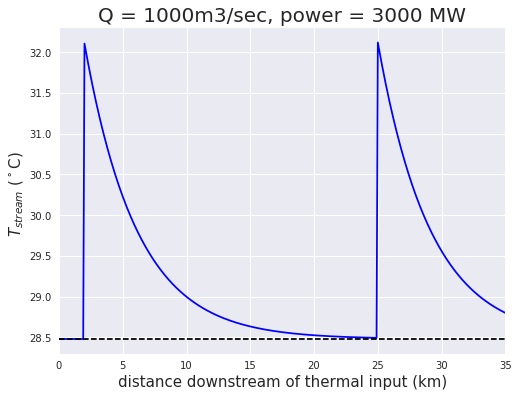

In [150]:
# --------------------------------------------------
#  general power plant plot
# --------------------------------------------------

i = 9  # scenario

distx2 = np.arange(km1,km2,input_vars['dist_between'])

plt.figure(figsize=[8,6])

plt.plot( distx2, T_stream_tot[i], color='blue')
plt.xlim([0,35])
plt.xlabel('distance downstream of thermal input (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
plt.axhline(y=28.48, color='k', linestyle='--')
plt.legend(fontsize=12)
plt.title('Q = '+ str(scenarios_tot_Q[i]) + 'm3/sec, power = '+ str(scenarios_tot_P[i]) + ' MW', fontsize=20)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


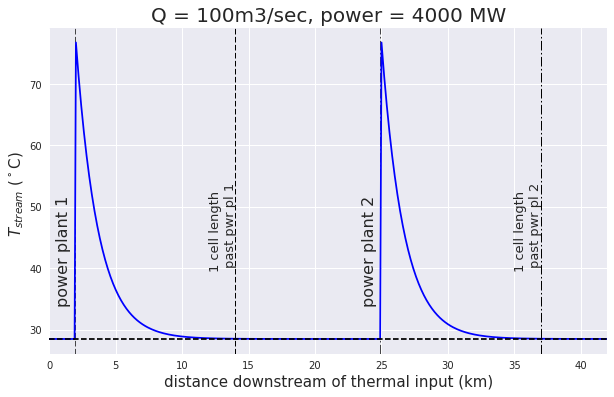

In [155]:
# --------------------------------------------------
#  two power plant plot with distance indicated
# --------------------------------------------------
 
    
i = 12

distx2 = np.arange(km1,km2,input_vars['dist_between'])

plt.figure(figsize=[10,6])

plt.axvline(x=2-0.1, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=12 + 2, linestyle='--',linewidth=1, color='black')
plt.text(14-2, 50, '1 cell length \n past pwr pl 1',fontsize=13, rotation=90)
plt.text(0.5, 50, 'power plant 1',fontsize=16, rotation=90)

plt.axvline(x=25-0.1, color='k', linestyle='-.', linewidth=0.7)
plt.axvline(x=12 + 25, linestyle='-.',linewidth=1, color='black')
plt.text(37 -2, 50, '1 cell length \n past pwr pl 2',fontsize=13, rotation=90)
plt.text(23.5, 50, 'power plant 2',fontsize=16, rotation=90)

plt.plot( distx2, T_stream_tot[i], color='blue')

plt.xlim([0,42])
plt.xlabel('distance downstream of thermal input (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
plt.axhline(y=28.4, color='k', linestyle='--')
plt.legend(fontsize=12)
plt.title('Q = '+ str(scenarios_tot_Q[i]) + 'm3/sec, power = '+ str(scenarios_tot_P[i]) + ' MW', fontsize=20)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


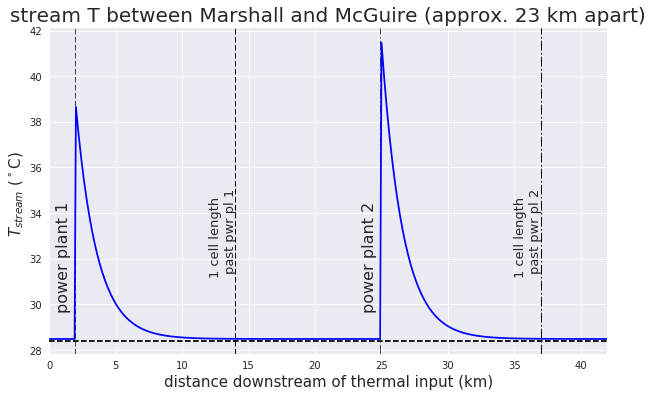

In [194]:
# --------------------------------------------------
#  two power plant plot with actual power and heat rate
# --------------------------------------------------
 

distx2 = np.arange(km1,km2,input_vars['dist_between'])

plt.figure(figsize=[10,6])

plt.axvline(x=2-0.1, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=12 + 2, linestyle='--',linewidth=1, color='black')
plt.text(14-2, 34, '1 cell length \n past pwr pl 1',fontsize=13, rotation=90)
plt.text(0.5, 34, 'power plant 1',fontsize=16, rotation=90)

plt.axvline(x=25-0.1, color='k', linestyle='-.', linewidth=0.7)
plt.axvline(x=12 + 25, linestyle='-.',linewidth=1, color='black')
plt.text(37 -2, 34, '1 cell length \n past pwr pl 2',fontsize=13, rotation=90)
plt.text(23.5, 34, 'power plant 2',fontsize=16, rotation=90)

plt.plot( distx2, T_stream_tot_2[0], color='blue')

plt.xlim([0,42])
plt.xlabel('distance downstream of thermal input (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
plt.axhline(y=28.4, color='k', linestyle='--')
plt.legend(fontsize=12)
plt.title('stream T between Marshall and McGuire (approx. 23 km apart)', fontsize=20)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


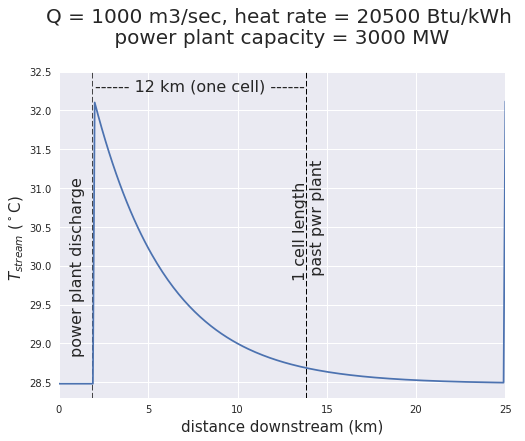

In [108]:
# --------------------------------------------------
#  plot one plant with distance
# --------------------------------------------------

#final_time = 30
#final_time = int(peakx + final_time)
line_styles = ['-','--','-.',':']
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colorx = ['1']*4*3 + ['3']*4*3   + ['5']*4*3 +  ['7']*4*3 
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colors =  sns.color_palette("cubehelix", 10)
colorx = ['1']*4 + ['3']*4   + ['5']*4 +  ['7']*4 

distx2 = np.arange(km1,km2,input_vars['dist_between'])

plt.figure(figsize=[8,6])

plt.axvline(x=1.85, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=12+1.85, linestyle='--',linewidth=1, color='black')
plt.text(12+1.1, 31, '1 cell length \n past pwr plant',fontsize=16, rotation=90)
plt.text(0.6, 31, 'power plant discharge',fontsize=16, rotation=90)

#plt.plot([2,12+2],[32.2,32.2],'k--', linewidth=2)
plt.text(2, 32.25, '------ 12 km (one cell) ------',fontsize=16)
    
#plt.axvline(x=24+1.73, linestyle='--',linewidth=1, color='black')
#plt.text(24+1.73,32, '2 cell length', rotation=90)

j = -1
for i in range(0,len(T_stream_tot)):
    #tempx = [x - T_equil[i].values for x in T_stream_tot[i][int(peakx):final_time]] #get temperature above T_eq
    ltyx = i%12  # get 1 of 4 line styles
    
    
    if scenarios_tot_Q[i] == 1000 and scenarios_tot_P[i] == 3000:
        j = j + 1
        ltyx = line_styles[int(j)]
        plt.plot( distx2, T_stream_tot[i], linestyle=ltyx)

        #plt.plot( distx[0:len(T_stream_tot[i])], T_stream_tot[i], )

plt.xlim([0,25])
plt.ylim([28.3,32.5])
plt.xlabel('distance downstream (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)

#plt.axhline(y=1, color='k', linestyle='--')
plt.legend(fontsize=12)
#plt.text(2,31,'thermal discharge', fontsize=13)
plt.title('Q = 1000 m3/sec, heat rate = 20500 Btu/kWh \n power plant capacity = 3000 MW \n', fontsize=20)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


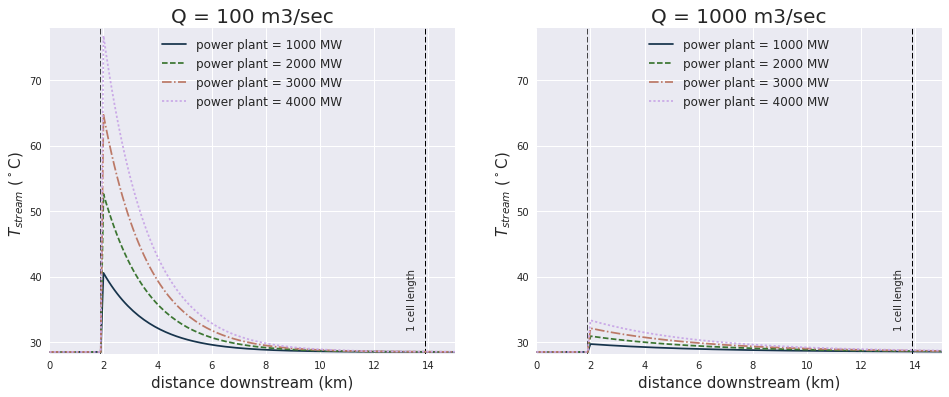

In [110]:
# --------------------------------------------------
#  plant capacity = 4000 MW, Q = 10 m3/sec
# --------------------------------------------------

distx2 = np.arange(km1,km2,input_vars['dist_between'])

line_styles = ['-','--','-.',':']
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colorx = ['1']*4*3 + ['3']*4*3   + ['5']*4*3 +  ['7']*4*3 
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colors =  sns.color_palette("cubehelix", 10)
colorx = ['1']*4 + ['3']*4   + ['5']*4 +  ['7']*4 

plt.figure(figsize=[16,6])
plt.subplot(121)
plt.axvline(x=1.88, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=12+1.88, linestyle='--',linewidth=1, color='black')
plt.text(11.5+1.73,40, '1 cell length', rotation=90)
#plt.axvline(x=24+1.73, linestyle='--',linewidth=1, color='black')
#plt.text(24+1.73,32, '2 cell length', rotation=90)

j = -1
for i in range(0,len(T_stream_tot)):
    #tempx = [x - T_equil[i].values for x in T_stream_tot[i][int(peakx):final_time]] #get temperature above T_eq
    ltyx = i%12  # get 1 of 4 line styles
    
    
    if scenarios_tot_Q[i] == 100:
        j = j + 1
        ltyx = line_styles[int(j)]
        plt.plot( distx2, T_stream_tot[i], linestyle=ltyx, color=colors[int(colorx[i])], 
                 label= 'power plant = ' + str(scenarios_tot_P[i]) + ' MW')

plt.xlim([0,15])
plt.ylim([28.2,78])
plt.xlabel('distance downstream (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
#plt.axhline(y=0, color='k')
#plt.axhline(y=1, color='k', linestyle='--')
plt.legend(fontsize=12)
#plt.text(3.5,1.1,'$\Delta$$T_{stream}$ = 1$^\circ$C', fontsize=13)
plt.title('Q = 100 m3/sec', fontsize=20)

plt.subplot(122)

#final_time = 30
#final_time = int(peakx + final_time)
line_styles = ['-','--','-.',':']
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colorx = ['1']*4*3 + ['3']*4*3   + ['5']*4*3 +  ['7']*4*3 
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colors =  sns.color_palette("cubehelix", 10)
colorx = ['1']*4 + ['3']*4   + ['5']*4 +  ['7']*4 


plt.axvline(x=1.88, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=12+1.88, linestyle='--',linewidth=1, color='black')
plt.text(11.5+1.73,40, '1 cell length', rotation=90)
#plt.axvline(x=24+1.73, linestyle='--',linewidth=1, color='black')
#plt.text(24+1.73,32, '2 cell length', rotation=90)

j = -1
for i in range(0,len(T_stream_tot)):
    #tempx = [x - T_equil[i].values for x in T_stream_tot[i][int(peakx):final_time]] #get temperature above T_eq
    ltyx = i%12  # get 1 of 4 line styles
    
    
    if scenarios_tot_Q[i] == 1000:
        j = j + 1
        ltyx = line_styles[int(j)]
        plt.plot( distx2, T_stream_tot[i], linestyle=ltyx, color=colors[int(colorx[i])], 
                 label= 'power plant = ' + str(scenarios_tot_P[i]) + ' MW')

plt.xlim([0,15])
plt.ylim([28.2,78])
plt.xlabel('distance downstream (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
#plt.axhline(y=0, color='k')
#plt.axhline(y=1, color='k', linestyle='--')
plt.legend(fontsize=12)
#plt.text(3.5,1.1,'$\Delta$$T_{stream}$ = 1$^\circ$C', fontsize=13)
plt.title('Q = 1000 m3/sec', fontsize=20)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


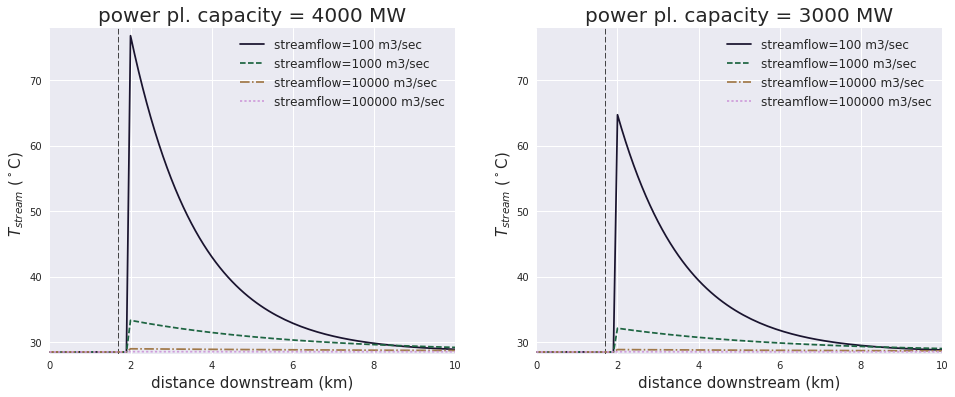

In [114]:
# --------------------------------------------------
#  plant capacity = 4000 MW, Q = 10 m3/sec
# --------------------------------------------------

distx2 = np.arange(km1,km2,input_vars['dist_between'])

line_styles = ['-','--','-.',':']
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colorx = ['1']*4*3 + ['3']*4*3   + ['5']*4*3 +  ['7']*4*3 
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colors =  sns.color_palette("cubehelix", 9)
colorx = ['1']*4 + ['3']*4   + ['5']*4 +  ['7']*4 
colorx = ['0']*1 + ['2']*1   + ['4']*1 +  ['6']*1 

plt.figure(figsize=[16,6])
plt.subplot(121)
plt.axvline(x=1.7, color='k', linestyle='--', linewidth=0.7)

j = -1
for i in range(0,len(T_stream_tot)):
    #tempx = [x - T_equil[i].values for x in T_stream_tot[i][int(peakx):final_time]] #get temperature above T_eq
    ltyx = i%12  # get 1 of 4 line styles
    
    
    if scenarios_tot_P[i] == 4000:
        j = j + 1
        ltyx = line_styles[int(j)]
        plt.plot( distx2, T_stream_tot[i], linestyle=ltyx, color=colors[int(colorx[j])], 
                 label= 'streamflow=' + str(scenarios_tot_Q[i]) + ' m3/sec')

plt.xlim([0,10])
plt.ylim([28.2,78])
plt.xlabel('distance downstream (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
plt.legend(fontsize=12)
plt.title('power pl. capacity = 4000 MW', fontsize=20)

plt.subplot(122)

line_styles = ['-','--','-.',':']
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colorx = ['1']*4*3 + ['3']*4*3   + ['5']*4*3 +  ['7']*4*3 
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colors =  sns.color_palette("cubehelix", 9)
colorx = ['1']*4 + ['3']*4   + ['5']*4 +  ['7']*4 
colorx = ['0']*1 + ['2']*1   + ['4']*1 +  ['6']*1 

plt.axvline(x=1.7, color='k', linestyle='--', linewidth=0.7)

j = -1
for i in range(0,len(T_stream_tot)):
    ltyx = i%12  # get 1 of 4 line styles
    
    
    if scenarios_tot_P[i] == 3000:
        j = j + 1
        ltyx = line_styles[int(j)]
        plt.plot( distx2, T_stream_tot[i], linestyle=ltyx, color=colors[int(colorx[j])], 
                 label= 'streamflow=' + str(scenarios_tot_Q[i]) + ' m3/sec')

plt.xlim([0,10])
plt.ylim([28.2,78])
plt.xlabel('distance downstream (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
plt.legend(fontsize=12)
plt.title('power pl. capacity = 3000 MW', fontsize=20)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


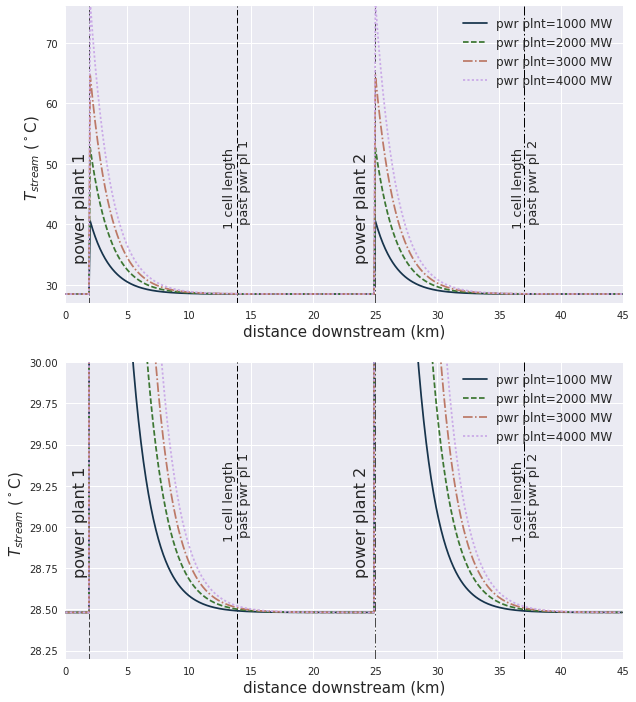

In [119]:
# ----------------------------------------------
# plot the same plot as above, but second row compressed axis
# ------------------------------------------

distx2 = np.arange(km1,km2,input_vars['dist_between'])

line_styles = ['-','--','-.',':']
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colorx = ['1']*4*3 + ['3']*4*3   + ['5']*4*3 +  ['7']*4*3 
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
colors =  sns.color_palette("cubehelix", 10)
colorx = ['1']*4 + ['3']*4   + ['5']*4 +  ['7']*4 

plt.figure(figsize=[10,12])
plt.subplot(211)


plt.axvline(x=1.88, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=12+1.88, linestyle='--',linewidth=1, color='black')
plt.text(11.3+1.45, 50, '1 cell length \n past pwr pl 1',fontsize=13, rotation=90)
plt.text(0.6, 50, 'power plant 1',fontsize=16, rotation=90)

plt.axvline(x=25, color='k', linestyle='-.', linewidth=0.7)
plt.axvline(x=12+25, linestyle='-.',linewidth=1, color='black')
plt.text(11.0+25, 50, '1 cell length \n past pwr pl 2',fontsize=13, rotation=90)
plt.text(23.3, 50, 'power plant 2',fontsize=16, rotation=90)

j = -1
for i in range(0,len(T_stream_tot)):
    ltyx = i%12  # get 1 of 4 line styles
    
    if scenarios_tot_Q[i] == 100:
        j = j + 1
        ltyx = line_styles[int(j)]
        plt.plot( distx2, T_stream_tot[i], linestyle=ltyx, color=colors[int(colorx[i])], 
                 label= 'pwr plnt=' + str(scenarios_tot_P[i]) + ' MW')

plt.xlim([0,45])
plt.ylim([27,76])
plt.xlabel('distance downstream (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
plt.legend(fontsize=12)


plt.subplot(212)

plt.axvline(x=1.88, color='k', linestyle='--', linewidth=0.7)
plt.axvline(x=12+1.88, linestyle='--',linewidth=1, color='black')
plt.text(11.3+1.45, 29.3, '1 cell length \n past pwr pl 1',fontsize=13, rotation=90)
plt.text(0.6, 29.3, 'power plant 1',fontsize=16, rotation=90)

plt.axvline(x=25, color='k', linestyle='-.', linewidth=0.7)
plt.axvline(x=12+25, linestyle='-.',linewidth=1, color='black')
plt.text(11.0+25, 29.3, '1 cell length \n past pwr pl 2',fontsize=13, rotation=90)
plt.text(23.3, 29.3, 'power plant 2',fontsize=16, rotation=90)

j = -1
for i in range(0,len(T_stream_tot)):
    ltyx = i%12  # get 1 of 4 line styles
       
    if scenarios_tot_Q[i] == 100:
        j = j + 1
        ltyx = line_styles[int(j)]
        plt.plot( distx2, T_stream_tot[i], linestyle=ltyx, color=colors[int(colorx[i])], 
                 label= 'pwr plnt=' + str(scenarios_tot_P[i]) + ' MW')

plt.xlim([0,45])
plt.ylim([28.2,30])
plt.xlabel('distance downstream (km)', fontsize=15)
plt.ylabel('$T_{stream}$ ($^\circ$C)  ', fontsize=15)
plt.legend(fontsize=12)



# ---------------------------------------------------------------
#       Plot the scenarios multiple scenarios
# ---------------------------------------------------------------


In [164]:
input_vars

,Q,stream_velocity,T_stream_i,T_dry_bulb,vap_press,q_ns,q_na,wind,power_plant_km1,power_plant_km2,dist_between
0,100.0,0.000527,28.481531,30.0,900.0,0.02,0.05,2.0,2.0,25.0,0.1


In [169]:
# when peak temperature will occur
peakx = input_vars['power_plant_km1'][0] * (1/input_vars['dist_between']) - (1/input_vars['dist_between'])

# post peak
km1_post_peak =  input_vars['power_plant_km1'][0] * (1/input_vars['dist_between']) - (1/input_vars['dist_between']) + 1*(1/input_vars['dist_between'])
km4_post_peak =  input_vars['power_plant_km1'][0] * (1/input_vars['dist_between']) - (1/input_vars['dist_between']) + 4*(1/input_vars['dist_between'])
km10_post_peak = input_vars['power_plant_km1'][0] * (1/input_vars['dist_between']) - (1/input_vars['dist_between']) + 10*(1/input_vars['dist_between'])

In [170]:
# ------------------------------------------
#     get delta T (difference between T_equil and maximum)
# --------------------------------------
T_stream_tot_x = T_stream_tot
T_equil_x = T_equil

delta_T_min_max = []
for i in range(0,len(T_stream_tot_x)):
    delta_T_min_max.append(np.max(T_stream_tot_x[i])-T_equil_x[i])
    
# ------------------------------------------
#     get delta T (difference between T_equil and 1 km after)
# --------------------------------------
delta_km1_post_peak = []
for i in range(0,len(T_stream_tot_x)):
    delta_km1_post_peak.append(T_stream_tot_x[i][int(km1_post_peak)]-T_equil_x[i])
    
# ------------------------------------------
#     get delta T (difference between T_equil and 4 km after)
# --------------------------------------
delta_km4_post_peak = []
for i in range(0,len(T_stream_tot_x)):
    delta_km4_post_peak.append(T_stream_tot_x[i][int(km4_post_peak)]-T_equil_x[i])
    
# ------------------------------------------
#     get delta T (difference between T_equil and 10 km after)
# --------------------------------------
delta_km10_post_peak = []
for i in range(0,len(T_stream_tot_x)):
    delta_km10_post_peak.append(T_stream_tot_x[i][int(km10_post_peak)]-T_equil_x[i])

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


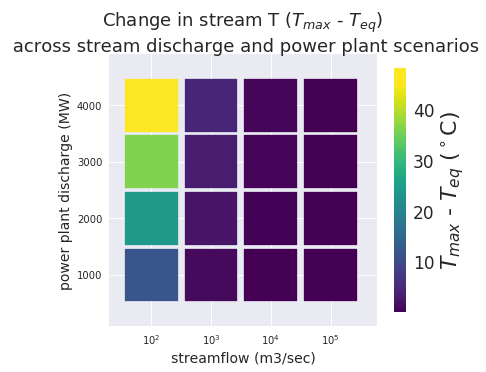

In [171]:
fig = pyplot.figure(figsize=[6,5])
ax = fig.add_subplot(1,1,1)

# setup the colormap
colormap = cm.jet
colormap = 'viridis'
minx = 0
maxx = 45
# ------- plot ---------
line = ax.scatter(scenarios_tot_Q,scenarios_tot_P,marker="s", s=2800, c=delta_T_min_max[:], 
                  cmap = colormap, vmin=minx, vmax=maxx)
ax.set_title('Change in stream T ($T_{max}$ - $T_{eq}$) \n across stream discharge and power plant scenarios', fontsize=18)
ax.set_xlabel('streamflow (m3/sec)', fontsize=14)
ax.set_ylabel('power plant discharge (MW)', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(20,600000)
ax.set_ylim(100,4900)

#plt.colorbar(line)
# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(delta_T_min_max[:])
cbar = plt.colorbar(scalarmappaple, shrink=0.9)
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$T_{max}$ - $T_{eq}$ ($^\circ$C)', size=22)
cbar.set_clim(vmin=minx, vmax=maxx)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


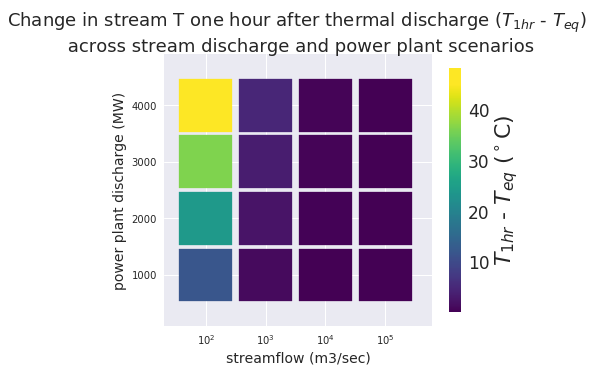

In [172]:
fig = pyplot.figure(figsize=[6,5])
ax = fig.add_subplot(1,1,1)

# setup the colormap
colormap = cm.jet
colormap = 'viridis'

# ------- plot ---------
line = ax.scatter(scenarios_tot_Q,scenarios_tot_P,marker="s", s=2800, c=delta_km1_post_peak[:], 
                  cmap = colormap, vmin=minx, vmax=maxx )
ax.set_title('Change in stream T one hour after thermal discharge ($T_{1hr}$ - $T_{eq}$) \n across stream discharge and power plant scenarios', fontsize=18)
ax.set_xlabel('streamflow (m3/sec)', fontsize=14)
ax.set_ylabel('power plant discharge (MW)', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(20,600000)
ax.set_ylim(100,4900)

# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(delta_T_min_max[:])
cbar = plt.colorbar(scalarmappaple, shrink=0.9)
cbar.ax.tick_params(labelsize=17)
cbar.set_clim(vmin=minx, vmax=maxx)
cbar.set_label(r'$T_{1hr}$ - $T_{eq}$ ($^\circ$C)', size=22)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


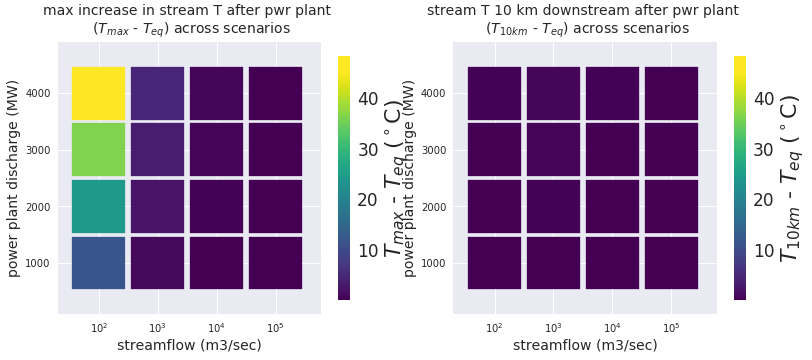

In [183]:
fig = pyplot.figure(figsize=[13,5])


ax = fig.add_subplot(1,2,1)

# setup the colormap
colormap = cm.jet
colormap = 'viridis'
minx = 0
maxx = 45
# ------- plot ---------
line = ax.scatter(scenarios_tot_Q,scenarios_tot_P,marker="s", s=2800, c=delta_T_min_max[:], 
                  cmap = colormap, vmin=minx, vmax=maxx)
ax.set_title('max increase in stream T after pwr plant \n ($T_{max}$ - $T_{eq}$) across scenarios', fontsize=14)
ax.set_xlabel('streamflow (m3/sec)', fontsize=14)
ax.set_ylabel('power plant discharge (MW)', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(20,600000)
ax.set_ylim(100,4900)

#plt.colorbar(line)
# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(delta_T_min_max[:])
cbar = plt.colorbar(scalarmappaple, shrink=0.9)
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$T_{max}$ - $T_{eq}$ ($^\circ$C)', size=22)
cbar.set_clim(vmin=minx, vmax=maxx)

ax = fig.add_subplot(1,2,2)

# setup the colormap
colormap = cm.jet
colormap = 'viridis'

# ------- plot ---------
line = ax.scatter(scenarios_tot_Q,scenarios_tot_P,marker="s", s=2800, c=delta_km10_post_peak[:], 
                  cmap = colormap, vmin=minx, vmax=maxx )
ax.set_title('stream T 10 km downstream after pwr plant \n ($T_{10km}$ - $T_{eq}$) across scenarios', fontsize=14)
ax.set_xlabel('streamflow (m3/sec)', fontsize=14)
ax.set_ylabel('power plant discharge (MW)', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(20,600000)
ax.set_ylim(100,4900)

# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(delta_T_min_max[:])
cbar = plt.colorbar(scalarmappaple, shrink=0.9)
cbar.ax.tick_params(labelsize=17)
cbar.set_clim(vmin=minx, vmax=maxx)
cbar.set_label(r'$T_{10km}$ - $T_{eq}$ ($^\circ$C)', size=22)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


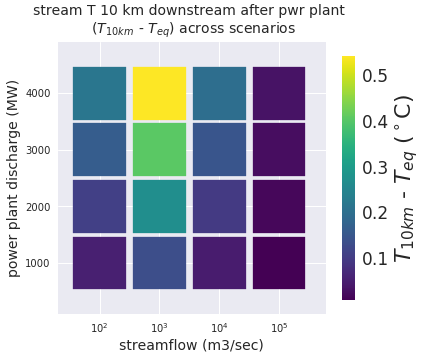

In [185]:
fig = pyplot.figure(figsize=[6,5])
ax = fig.add_subplot(1,1,1)

# setup the colormap
colormap = cm.jet
colormap = 'viridis'

# ------- plot ---------
line = ax.scatter(scenarios_tot_Q,scenarios_tot_P,marker="s", s=2800, c=delta_km10_post_peak[:], cmap = colormap )
ax.set_title('stream T 10 km downstream after pwr plant \n ($T_{10km}$ - $T_{eq}$) across scenarios', fontsize=14)
ax.set_xlabel('streamflow (m3/sec)', fontsize=14)
ax.set_ylabel('power plant discharge (MW)', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(20,600000)
ax.set_ylim(100,4900)

# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(delta_km10_post_peak[:])
cbar = plt.colorbar(scalarmappaple, shrink=0.9)
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$T_{10km}$ - $T_{eq}$ ($^\circ$C)', size=22) 

# --------------------------------------------------------------------------
#         Plot empirical data on top of sensitivity analysis
# --------------------------------------------------------------------------

In [135]:
#from mpl_toolkits.axes_grid1 import AxesGrid
orig_cmap = plt.get_cmap("plasma")

In [136]:
# ---------------- USGS flow and temp sites for each once-thru plant (manually identified) ----------
#file_temp = '/raid3/rniemeyr/RBM/thermal_plant_sensitivity/data/thermal_plant_USGS_temp_flow_updated.csv'
file_temp = '/raid3/rniemeyr/RBM/thermal_plant_sensitivity/analysis/thermal_plant_USGS_temp_flow.csv'
data_summary = pd.read_csv(file_temp)

# -------------- list of USGS temperature and flow sites near once-through power plant sites -----
file_name = '/raid3/rniemeyr/RBM/thermal_plant_sensitivity/data/USGS_near_power_plants_site_list.csv'
USGS_power_summary_names = pd.read_csv(file_name,  nrows=1, header=None)
USGS_power_summary = pd.read_csv(file_name,   sep=',', dtype={'SiteNumber': object}) #sep='","'
USGS_power_summary = USGS_power_summary.rename(columns=lambda x: x.strip())  # strip white space

# ---------- power plant data - Yifan version ---------------------
file_temp = '/raid3/rniemeyr/RBM/data/power_plants/SERC_map_powerplant_info_cata.csv'
power_plant_data = pd.read_csv(file_temp)
power_plant_data = power_plant_data[power_plant_data.Cooling_cata==1] # only use once-through data

In [137]:
USGS_temp_summary = pd.read_csv('/raid3/rniemeyr/RBM/thermal_plant_sensitivity/analysis/USGS_temp_near_power_plants_site.csv')
USGS_flow_summary = pd.read_csv('/raid3/rniemeyr/RBM/thermal_plant_sensitivity/analysis/USGS_flow_near_power_plants_site.csv')


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


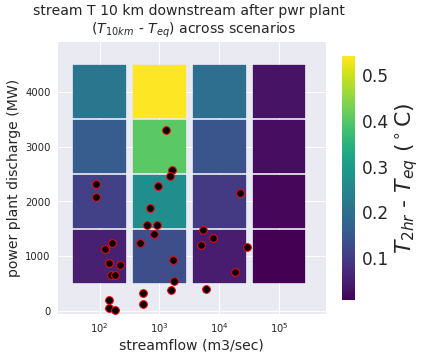

In [186]:
fig = pyplot.figure(figsize=[6,5])
ax = fig.add_subplot(1,1,1)

# setup the colormap
colormap = cm.jet
colormap = 'viridis'

# ------- plot ---------
line = ax.scatter(scenarios_tot_Q,scenarios_tot_P,marker="s", s=2800, c=delta_km10_post_peak[:], cmap = colormap )
ax.set_title('stream T 10 km downstream after pwr plant \n ($T_{10km}$ - $T_{eq}$) across scenarios', fontsize=14)
ax.set_xlabel('streamflow (m3/sec)', fontsize=14)
ax.set_ylabel('power plant discharge (MW)', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(20,600000)
ax.set_ylim(-50,4900)

plt.scatter(USGS_flow_summary['min_mean_wkly_flow_cfs_min']/m3sec_to_ft3sec , power_plant_data['Capacity (MW)'],s=60,
            facecolor='black',color='red', lw=1, zorder=2)

# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=colormap)
scalarmappaple.set_array(delta_km10_post_peak[:])
cbar = plt.colorbar(scalarmappaple, shrink=0.9)
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$T_{2hr}$ - $T_{eq}$ ($^\circ$C)', size=22)

# --------------------------------------------------------------------------
#         Practice (Extra) code
# --------------------------------------------------------------------------

In [ ]:
def calc_stream_temperature_1_plantb(T_stream, T_eq, k_coeff, q_power, Q, depth, impulse_fxn2, hrx, subhrx,hr_impulse, time_stepx):
    
    """
    
    Equation to calculate the stream temperature
    based on the analytical solution of the Edenger et al. (1968), equation #19
    
    """

    timex = (hrx + subhrx/(len(steps_per_hr)))*3600 # calculate time interval in seconds
    hr_impulse = hr_impulse * 3600 #- 3600 # convert time of power plant effluent impulse in seconds
    k_coeff = k_coeff * kcal_to_J # convert kcal/sec*m2*C to Joules/sec*m2*C
    alpha = k_coeff/(water_density * c_p_j * depth) # alpha parameter from solution
    beta = (q_power * a_const)/(water_density * c_p_j * Q) # calculate beta parameter
    power_x  = impulse_fxn2[hrx]*beta*exp((-1)*alpha[0]*(timex - hr_impulse)) # calculate power plant term
    stream_x = (T_stream - T_eq)*exp((-1)*alpha[0]*timex) + T_eq + power_x   #  calculate stream temperature at timex
    print('timex: ',np.round(timex), 'power_x: ', power_x,'hrx',hrx, 'impulse_fxn2[hrx]: ',impulse_fxn2[hrx],
          'exp: ',np.round(exp((-1)*alpha[0]*(timex - hr_impulse)), 2))
    return stream_x

In [ ]:
# --------------------------------------------------
#  Analytial Solution - original code using time (instead of distance)
# ---------------------------------------

# --------- input variables ------------
# Q(m3/sec), depth(m), stream_velocity(km/sec) T_stream(deg C), dbt (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec),
# q_na (kcal/m2*sec),  wind (m/sec), time power plant effluent is discharged (hr), time step (hr)
input_vars = pd.DataFrame([100,  4, 5.27e-4,  28.481531,  30, 900,  0.02, 0.05,  2, 0, 2, 0.1])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','depth','stream_velocity', 'T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant', 'power_plant_hr', 'time_step']
a_const = 1
heat_x = 20500  # constant heat rate in Btu/kWh (max observed in SERC = 20,500)

# ----- establish time series with power plant impulse ---------
hr1 = 0 # first hour
hr2 = 30 # final hour
impulse_time_series = impseq2(int(input_vars['power_plant_hr'][0]),hr1,hr2)

# ------- flow and power plant capacity scenarios ------------
power_plant_range = [1000,2000,3000,4000] # power plant capacity (MW)
Q_range = [100,1000,10000,100000] # discharge range (m3/sec)

power_plant_range = [4000] # power plant capacity (MW)
Q_range = [100] # discharge range (m3/sec)

# ------- data frames and lists to write data -------
T_stream_list = pd.DataFrame()
T_stream_tot = []
scenarios_tot_Q = []
scenarios_tot_P = []
T_equil = []

# ------------------- loop through all power plant capacity scenarios ------------------
for power_x in power_plant_range:
    
    # --------- loop through all flow scenarios ---------
    for flow_x in Q_range:
        
        T_stream_list2 = [] # empty list to write stream T time series

        # ------------- calculate surface energy, T_equil., and k_coeff -------    
        q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],
                input_vars['vap_press'],input_vars['q_ns'],input_vars['q_na'],
                input_vars['wind'])
        T_equil.append(T_eq)
        # -------------------- calculate power plant waste heat output ----------------
        #q_power = power_plant_efficiency(power_x, 0.35)
        waste_heat = waste_heat_fxn(power_x, heat_x) # output [J/sec]
        
        # --------------- calculate flow depth --------------------
        depth_x = a_d * ((flow_x*m3sec_to_ft3sec)**b_d) # depth in feet
        depth_x = depth_x /m_to_ft  # depth in meters

        # -------------- print scenarios -----------
        print('power: ',power_x, ' flow: ',flow_x, ' depth: ',depth_x)   
        
        # ------------- loop through each hour of time series -----------
        for i in range(len(impulse_time_series)):

            steps_per_hr = list(range(0,int(1/input_vars['time_step']))) # list with total time steps in each hour
            
            # update steps_per_hr if more than one time step per hour
            if len(steps_per_hr) < 1:
                steps_per_hr =  list([1])
            
            # loop through each time step in the hour and calculate stream temperature
            for j in steps_per_hr:
                T_stream_new = calc_stream_temperature_1_plantb(input_vars['T_stream_i'], T_eq, k_coeff, waste_heat, 
                    flow_x, depth_x, 
                    impulse_time_series, i, j,int(input_vars['power_plant_hr'][0]),input_vars['time_step'] )
                
                T_stream_list2.append(T_stream_new)

        # --------- write each scenario ------
        scenarios_tot_Q.append(flow_x)
        scenarios_tot_P.append(power_x)
        # ------- append new time series of stream temperatures --------
        T_stream_tot.append(T_stream_list2)
        
T_stream_to_orig = T_stream_tot

In [76]:
def calc_power_energy(T_stream, T_eq, k_coeff, q_power, Q, impulse_fxn, hrx):
    print('power input: ', q_power, 'impulse: ',  impulse_fxn[hrx-1], 'water_dense: ',water_density, 'cp',c_p_j,'Q: ', Q)
    hrx = hrx - 1 # to match the python index system where 0 is first index
    power_x  = (q_power * impulse_fxn[hrx])/(water_density*c_p_j*Q)
    stream_x = k_coeff * (T_eq - T_stream)
    dT = stream_x + power_x
    print('power: ',power_x,'stream_x: ',stream_x.values, 'dT: ',dT.values)
    T_new = dT + T_stream
    
    return T_new

In [67]:
q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],input_vars['vap_press'],
                                         input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

dayx = 1
impulse_fxn = impseq(dayx,1,10)
T_stream_new = calc_power_energy(input_vars['T_stream_i'].values, T_eq, k_coeff, input_vars['power_plant'].values, 
                                 input_vars['Q'].values, impulse_fxn, dayx)
print(T_stream_new)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [72]:
impulse_time_series = impseq(1,hr1,hr2)

q_surf, T_eq, k_coeff = calc_surf_energy(input_vars['T_stream_i'],input_vars['T_dry_bulb'],input_vars['vap_press'],
                            input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

T_stream_new = calc_power_energy(input_vars['T_stream_i'], T_eq, k_coeff, 10000, 
                             input_vars['Q'].values, impulse_time_series, 1)
#print(input_vars['T_stream_i'].values, T_stream_new.values)

power input:  10000 impulse:  1 water_dense:  1000 cp 4148.4 Q:  [ 50.]
power:  [  4.82113586e-05] stream_x:  0    0.373923
dtype: float64


In [68]:
              read(38,*) z, T_i, dbt,ea, q_ns, q_na, wind
              call energy(T_i, q_surf, dbt, ea,q_ns, q_na, wind, T_equil, k_coeff)
              q_dot=(q_surf/(z*rfac))
              q_surf_tot = q_surf_tot + q_dot*dt_calc ! adding up surface energy


SyntaxError: invalid syntax (<ipython-input-68-786fb29d0af1>, line 1)

In [20]:
len(pd.date_range(dt.datetime(1949,1,1),dt.datetime(2010,9,30), freq='H'))

541249

In [22]:
len(pd.date_range(dt.datetime(1950,1,1),dt.datetime(2010,9,30), freq='H'))

532489

In [ ]:
# --------------------------------------------------
#  Numerical Solution - loop through hours (calculate T_eq and k_coeff each time step)
# ---------------------------------------

# ----- establish time series with power plant impulse
impulse_time_series = impseq(int(input_vars['power_plant_hr'][0]),hr1,hr2)

first_run = True
T_stream_list2 = pd.DataFrame()

for i in range(len(impulse_time_series)):
    
    steps_per_hr = list(np.arange(0,int(1/input_vars['time_step'])))

    if len(steps_per_hr) < 1:
        steps_per_hr =  list([1])
    #print(steps_per_hr)
    for j in steps_per_hr:
        
        # -------------- establish initial stream temperature ------------
        if first_run:
            T_stream_x = input_vars['T_stream_i']
            first_run = False

        # ------------ use previous temperature for stream T ----------
        else:
            T_stream_x = T_stream_new

        # ------------- calculate surface energy, T_equil., and k_coeff -------    
        q_surf, T_eq, k_coeff = calc_surf_energy(T_stream_x,input_vars['T_dry_bulb'],input_vars['vap_press'],
                                             input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])
        #print('T_eq: ', T_eq[0], 'T_stream_x',T_stream_x[0])
        # -------------------- calculate power plant efficiency ----------------
        q_power = power_plant_efficiency(input_vars['power_plant'].values)

        # ------------------- calculate change in stream T from power plant and T_equil ----------
   
        T_stream_new = calc_change_in_stream_T(T_stream_x, T_eq, k_coeff, q_power, 
                input_vars['Q'].values, input_vars['depth'], 0, i,j,input_vars['time_step'] )
        datax = pd.DataFrame([i + j/(len(steps_per_hr)),  T_stream_new[0]])
        T_stream_list2 = T_stream_list2.append(datax.transpose())
T_stream_list2.columns = ['time_step','T_stream']
T_stream_list2.index = T_stream_list2.time_step     

In [ ]:
# --------------------------------------------------
#  loop through hours  - use q_surf
# ---------------------------------------
#depth(m), T_stream(deg C), dbt (deg C), vapor_pressure (mb), q_ns (kcal/m2*sec), q_na (kcal/m2*sec), 
#    wind (m/sec), hour power plant effluent is discharged (hr), time step (hr)

input_vars_loop = pd.DataFrame([4,  18.5,  20, 900,  0.02, 0.05,  2, 30, 0.1])
input_vars = input_vars.transpose()
#input_vars.columns = ['depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant_hr', 'time_step']
hr1 = 1 # first hours
hr2 = 60 # final hour

input_vars = pd.DataFrame([50,  4,  18.5,  20, 900,  0.02, 0.05,  2, 0, 30, 0.1])
#input_vars = pd.DataFrame([1000,  2,  10,  25, 900,  0.02, 0.05,  2, 0, 5, 0.05])
input_vars = input_vars.transpose()
input_vars.columns = ['Q','depth','T_stream_i','T_dry_bulb','vap_press','q_ns','q_na','wind','power_plant', 'power_plant_hr', 'time_step']
hr1 = 1 # first hours
hr2 = 60 # final hour


power_plant_range = [1000,2000,3000,4000] # power plant capacity (MW)
Q_range = [10,100,1000,10000] # discharge range (m3/sec)
Q_range = [50,500,5000,50000] # discharge range (m3/sec)

T_stream_tot = []
scenarios_tot_Q = []
scenarios_tot_P = []
# ----- establish time series with power plant impulse
impulse_time_series = impseq(int(input_vars['power_plant_hr'][0]),hr1,hr2)

for power_x in power_plant_range:
    
    for flow_x in Q_range:
        
        first_run = True
        T_stream_list2 = []

        for i in range(len(impulse_time_series)):

            steps_per_hr = list(range(0,int(1/input_vars['time_step'])))

            #print(len(steps_per_hr))
            if len(steps_per_hr) < 1:
                steps_per_hr =  list([1])
            #print(steps_per_hr)
            for j in steps_per_hr:

                # -------------- establish initial stream temperature ------------
                if first_run:
                    T_stream_x = input_vars['T_stream_i']
                    first_run = False

                # ------------ use previous temperature for stream T ----------
                else:
                    T_stream_x = T_stream_new

                # ------------- calculate surface energy, T_equil., and k_coeff -------    
                q_surf, T_eq, k_coeff = calc_surf_energy(T_stream_x,input_vars['T_dry_bulb'],input_vars['vap_press'],
                                                     input_vars['q_ns'],input_vars['q_na'],input_vars['wind'])

                # -------------------- calculate power plant efficiency ----------------
                q_power = power_plant_efficiency(power_x)

                # ------------------- calculate change in stream T from power plant and T_equil ----------
                T_stream_new = calc_power_energy2(T_stream_x, q_surf, k_coeff, q_power, 
                                             flow_x, input_vars['depth'], impulse_time_series, i,input_vars['time_step'] )
                T_stream_list2.append(T_stream_new)
                
                
        scenarios_tot_Q.append(flow_x)
        scenarios_tot_P.append(power_x)
        T_stream_tot.append(T_stream_list2)
    